In [6]:
# import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
import numpy as np
import matplotlib.pyplot as plt

In [35]:
datagen = ImageDataGenerator(
            rescale=1./255,
#             featurewise_center=True,
#             featurewise_std_normalization=True,
#             rotation_range=20,
#             width_shift_range=0.2,
#             height_shift_range=0.2,
#             horizontal_flip=True,
            fill_mode='constant',
            cval = 1.0,
            validation_split=0.2
            )

In [36]:
path = './extracted_letter_2000/'
train_generator = datagen.flow_from_directory(path,
        target_size=(96, 96),
        shuffle=True,
        color_mode="rgb",
        class_mode='categorical',subset='training')
val_generator = datagen.flow_from_directory(path,
        target_size=(96, 96),
        shuffle=True,
        color_mode="rgb",
        class_mode='categorical',subset='validation')

Found 5427 images belonging to 27 classes.
Found 1344 images belonging to 27 classes.


In [37]:
train_generator.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'background': 26}

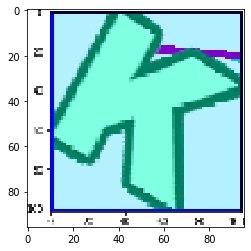

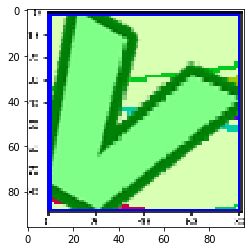

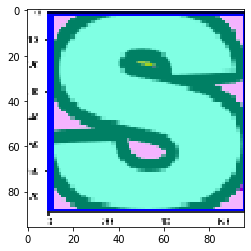

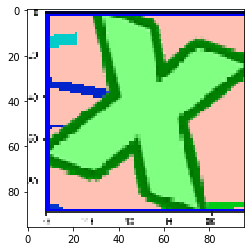

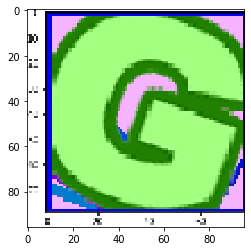

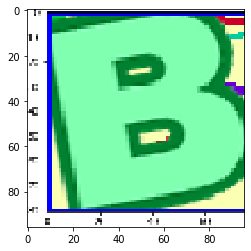

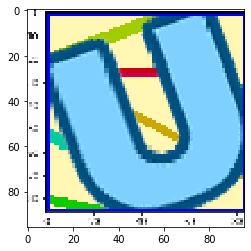

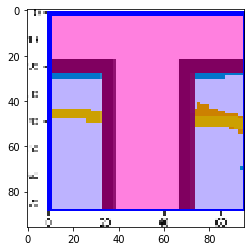

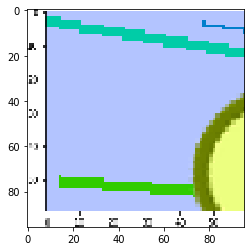

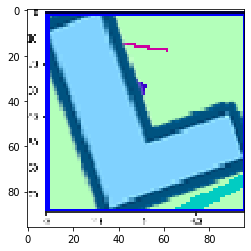

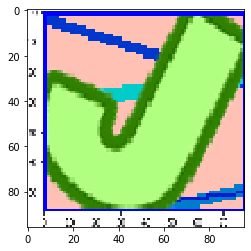

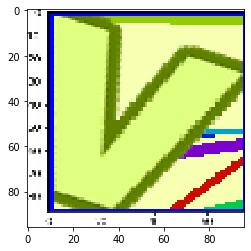

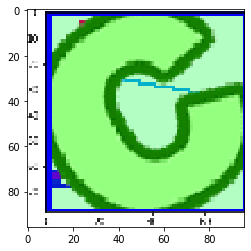

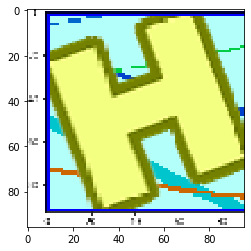

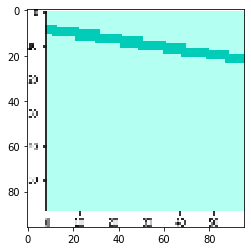

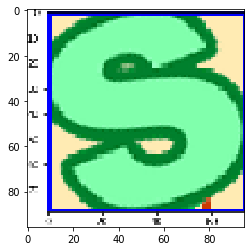

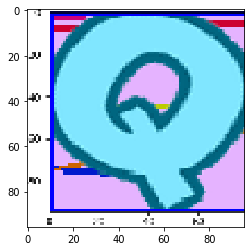

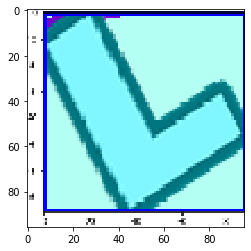

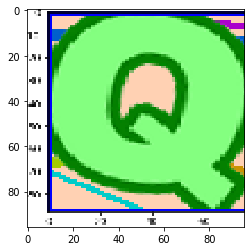

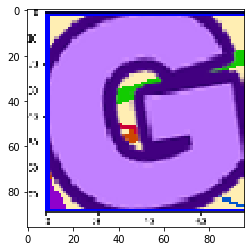

In [38]:
imgs = train_generator.next()
# plt.figure()
for i,img in enumerate(imgs[0]):
#     print(imgs[0].shape)
    if i<20:
        plt.imshow(img)
        plt.show()
        

In [5]:
def seq_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding='same',input_shape=(96,96,3),activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.3))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(27,activation="softmax"))
    return model

In [6]:
model = seq_model()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)               

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
model.fit_generator(train_generator,epochs=4,verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/4
170/170 [==============================] - 139s 817ms/step - loss: 1.3630 - acc: 0.6832
Epoch 2/4
170/170 [==============================] - 163s 957ms/step - loss: 0.0899 - acc: 0.9860
Epoch 3/4
170/170 [==============================] - 91s 538ms/step - loss: 0.0567 - acc: 0.9893
Epoch 4/4
 99/170 [================>.............] - ETA: 33s - loss: 0.0342 - acc: 0.9940

In [9]:
model.evaluate_generator(val_generator,verbose=1)

45/45 [==============================] - 22s 499ms/step


[0.09676649873564118, 0.9832519190509421]

In [10]:
model.save('multiclass_alphabet_v2.h5')

In [5]:
from keras.models import load_model
new_model = load_model('./multiclass_alphabet_v2.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
new_model.predict_classes(imgs[0][30:31])

array([0])

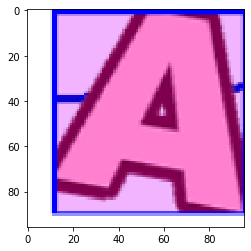

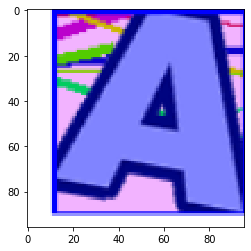

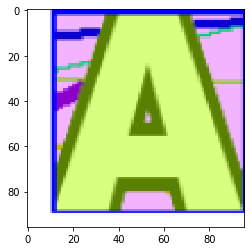

In [40]:
import cv2
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def istaken(box,arr):
    for bbox in arr:
        if iou(bbox,box)>0.5:
            return False
    return True



image = cv2.imread('./train_1/train/AAA.png')
arr = []
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret, thresh=cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
contours,_=cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

for c in contours:
    x,y,w,h=cv2.boundingRect(c)
    if w>50 and h>60 and h>0.8*w and istaken((x,y,x+w,y+h),arr):
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
        arr.append((x,y,x+w,y+h))

arr = sorted(arr,key = lambda x:x[0])
i = 0
out = ''
img_t = []
flag = True
#         f,ax = plt.subplots(1,4)
# f = plt.figure()
for i,bbox in enumerate(arr):

    crop_img = image[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    img_border = cv2.copyMakeBorder(crop_img,0,5,10,0,cv2.BORDER_CONSTANT,value=[255,255,255])
    img_t.append(cv2.resize(img_border,(96,96)))
    plt.imshow(img_t[-1])
    plt.show()  

img_t = np.array(img_t)
# predict_t = model.predict_classes(img_t)
# #         print(predict_t)
# for index in predict_t:
# #             print(index.shape)
#     letter = key_value[index]
#     if letter!='background':
#         out+=letter

# codes.append(out)
# numChars.append(len(out))

# #         for i,c in enumerate(name[0]):
# #             if not os.path.isdir(generate_img+c):
# #                 os.makedirs(generate_img+c)
# #             try:
# #                 bbox = arr[i]
# #                 plt.imshow()
# #                 plt.savefig(generate_img+c+'/'+name[0]+str(i))
# #             except:
# #                 continue
# #     #     plt.imshow(image)
# #     #     plt.show()
# sys.stdout.write('\r'+str(k))
# #         print(name[0],out)
# return numChars,codes

[0 0 0]


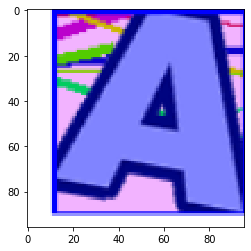

In [41]:
print(new_model.predict_classes(img_t[0:3]))
plt.imshow(img_t[1])

In [30]:
new_model.evaluate_generator(val_generator,verbose=1)

42/42 [==============================] - 3s 70ms/step


[0.0799169759875873, 0.9895833333333334]

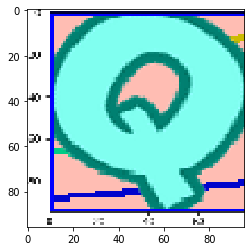

In [33]:
plt.imshow(val_generator.next()[0][0])